# Telco Churn Report

## Project Goals

- The goal of this project is to discover the primary features driving customer churn at Telco. My initial hypothesis is that the top features affecting churn are tenure, monthly charges, and contract type. Other features that possibly affect churn are whether or not the customer has extra services (streaming, online security, etc.), payment type, and internet service type.

- Questions:

    - What are the main features driving customer churn at Telco?

    - Is tenure indicative of churn? When are customers most likely to leave?

    - Are monthly charges related to churn, and if so, how?

    - Do additional services keep customers from churning?

    - How does contract type affect customer churn?

## Project Planning

- Acquire the dataset from the Codeup database using SQL
- Prepare the data with the intent to discover the main drivers of customer churn; clean the data and encode categorical features if necessary; ensure that the data is tidy
- Split the data into train, validate, and test datasets using a 60/20/20 split
- Explore the data:
    - Univariate, bivariate, and multivariate analyses; statistical tests for significance, find the three primary features affecting customer churn
    - Create graphical representations of the analyses
    - Answer questions about the data
    - Document findings
- Train and test at least three models:
    - Establish a baseline
    - Select key features and train multiple classification models
    - Test the model on the validate set, adjust for overfitting if necessary
- Select the best model for the project goals:
    - Determine which model performs best on the validate set
- Test and evaluate the model:
    - Use the model on the test set and evaluate its performance (classification report, confusion matrix, etc.)
    - Visualize the data using an array of probabilities on the test set
- Document key findings and takeaways, answer the questions in the final report

## Executive Summary



- After running four models on my train and validate sets, I decided to use the random forest model because it provided the highest accuracy overall. The difference in accuracy was minimal between the models, however. 
- I used the eleven most significant features for customer churn (tenure, monthly charges, contract type, payment type, paperless billing, extra services, streaming, senior citizen, dependents, partner). I selected a maximum depth of 14 and a minimum sample leaf size of 14. The accuracy of the model on the test set was 80 percent.

- Takeaways: the biggest drivers of churn are monthly charges, tenure, and contract type. Customers with low monthly charges, high tenure, and a two-year contract have the lowest likelihood of churn. The models all performed similarly for accuracy, but none of the models performed above baseline for recall. If Telco wants to predict customers who actually churn, I would recommend a different model or retraining the selected model for increased recall.


## Acquire Data

In [1]:
# import required libraries for project

import os
import pandas as pd
import numpy as np
import acquire
import prepare
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
# obtain the dataset using prepare.py function 

telco = prepare.prep_telco()

/Users/dashiellbringhurst/codeup-data-science/classification_project/prepare.py:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  telco['payment_type'] = telco.payment_type.str.replace('(','').str.replace(')', '').str.replace('Bank transfer automatic', 'auto').str.replace('Credit card automatic', 'auto')
/Users/dashiellbringhurst/codeup-data-science/classification_project/prepare.py:27: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  telco['total_charges'] = telco.total_charges.str.replace('$','').str.replace(',','').str.replace(' ','').fillna(0)


In [3]:
# confirm columns and values were acquired correctly

telco.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,extras,streaming
0,2,1,2,0002-ORFBO,0,0,1,1,9,1,...,0,1,65.6,593.30,0,One year,DSL,manual,2,1
1,2,1,1,0003-MKNFE,1,0,0,0,9,1,...,1,0,59.9,542.40,0,Month-to-month,DSL,manual,0,1
2,1,2,1,0004-TLHLJ,1,0,0,0,4,1,...,0,1,73.9,280.85,1,Month-to-month,Fiber optic,manual,1,0
3,1,2,1,0011-IGKFF,1,1,1,0,13,1,...,1,1,98.0,1237.85,1,Month-to-month,Fiber optic,manual,2,2
4,2,2,1,0013-EXCHZ,0,1,1,0,3,1,...,0,1,83.9,267.40,1,Month-to-month,Fiber optic,manual,1,1


In [4]:
# general information about the dataset

telco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   int64  
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   int64  
 7   dependents                7043 non-null   int64  
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   int64  
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   int64  
 12  online_backup             7043 non-null   int64  
 13  device_protection         7043 non-null   int64  
 14  tech_sup

### Acquisition Takeaways

- I acquired the Telco dataset from the Codeup database using a SQL query. This query has been written into a function in the acquire.py file and requires credentials for access.

- The dataset contains 7043 non-null observations and 26 columns. All string columns have been converted to integers or floats, with the exception of customer id, but I retained the string columns for reference and readability of graphs.

## Prepare Data

In [5]:
# split the data using the split_data function from prepare.py

train_telco, validate_telco, test_telco = prepare.split_data(telco, 'churn')

In [6]:
# make sure the data is split correctly (60/20/20)

train_telco.shape, validate_telco.shape, test_telco.shape

((4225, 26), (1409, 26), (1409, 26))

- The datasets are split 60/20/20 and stratified on 'churn'

In [7]:
# information about the numeric columns, including means and standard deviations

train_telco.describe()

,payment_type_id,internet_service_type_id,contract_type_id,gender,senior_citizen,partner,dependents,tenure,phone_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,extras,streaming
count,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,...,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4220.000000,4225.000000,4225.000000,4225.000000
mean,2.320000,1.878107,1.692544,0.507456,0.163314,0.493728,0.298225,32.736568,0.905325,0.281893,...,0.347929,0.289231,0.386982,0.391479,0.595976,64.975325,2317.808898,0.265325,1.261065,0.778462
std,1.157093,0.735695,0.838753,0.500004,0.369695,0.500020,0.457533,24.518294,0.292800,0.449975,...,0.476370,0.453459,0.487117,0.488139,0.490760,30.184347,2277.970403,0.441559,1.281704,0.854001
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.850000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,35.750000,416.200000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,30.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,70.550000,1415.425000,0.000000,1.000000,1.000000
75%,3.000000,2.000000,2.000000,1.000000,0.000000,1.000000,1.000000,56.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,90.050000,3858.900000,1.000000,2.000000,2.000000
max,4.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,118.750000,8684.800000,1.000000,4.000000,2.000000


## Explore Data

### Univariate analysis

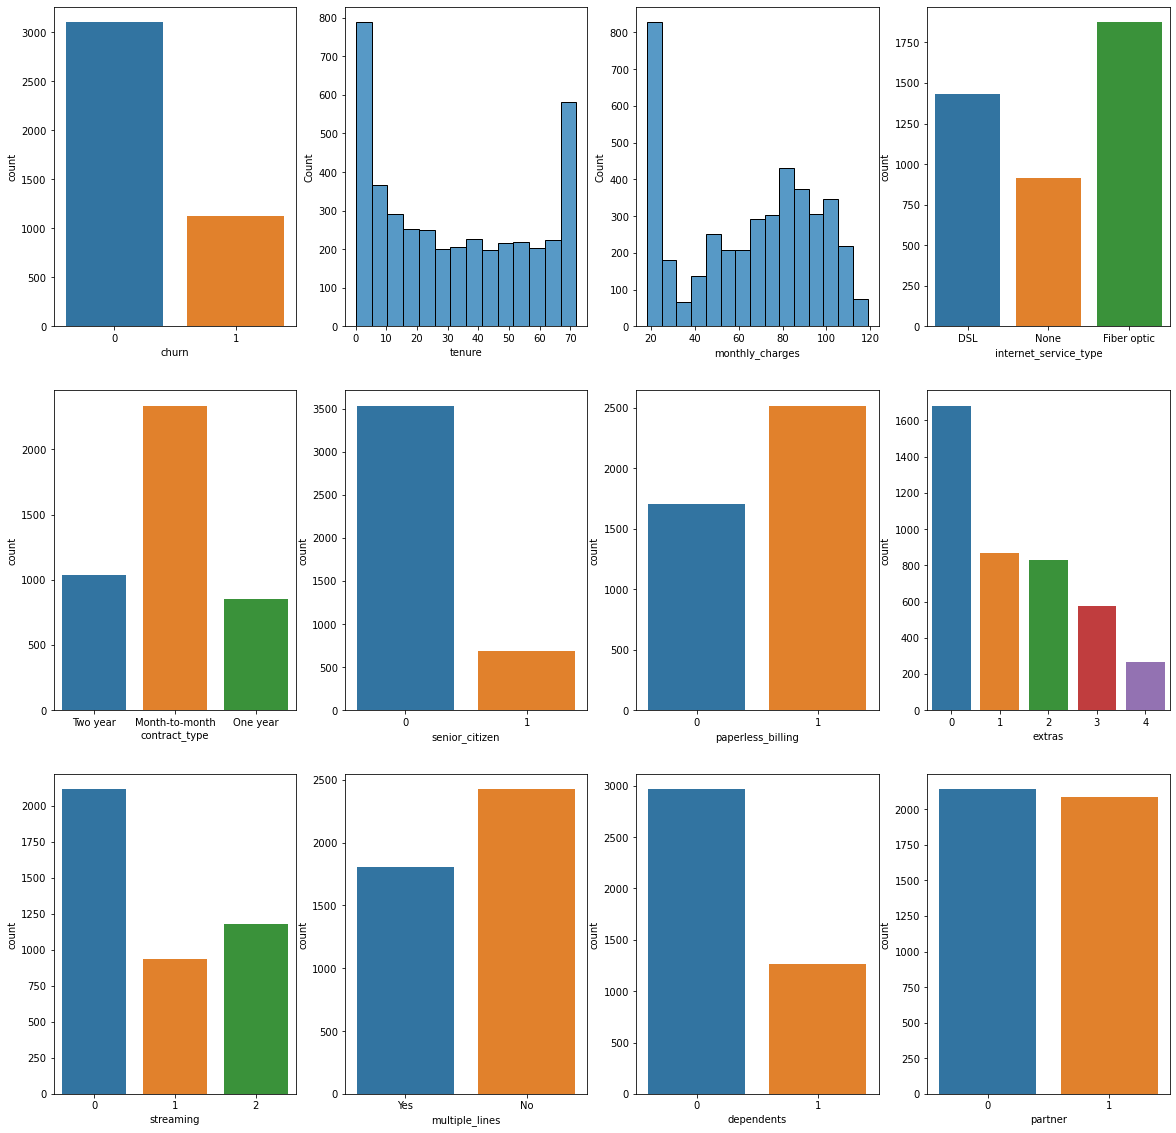

In [8]:
# graphical representations of univariate analysis for selected features displayed with three rows and four columns

plt.figure(figsize=[20,20])
plt.subplot(341)
sns.countplot(x=train_telco.churn)
plt.subplot(342)
sns.histplot(x=train_telco.tenure)
plt.subplot(343)
sns.histplot(x=train_telco.monthly_charges)
plt.subplot(344)
sns.countplot(x=train_telco.internet_service_type)
plt.subplot(345)
sns.countplot(x=train_telco.contract_type)
plt.subplot(346)
sns.countplot(x=train_telco.senior_citizen)
plt.subplot(347)
sns.countplot(x=train_telco.paperless_billing)
plt.subplot(348)
sns.countplot(x=train_telco.extras)
plt.subplot(349)
sns.countplot(x=train_telco.streaming)
plt.subplot(3,4,10)
sns.countplot(x=train_telco.multiple_lines)
plt.subplot(3,4,11)
sns.countplot(x=train_telco.dependents)
plt.subplot(3,4,12)
sns.countplot(x=train_telco.partner)

plt.show()

#### Findings:

- 26.5 percent of customers churned

- Average tenure is 32.7 months, but most customers are between 0-5 and 65-70 months.

- Average monthly charge is 65, but most customers pay between 18-30

- 16 percent of customers are senior citizens

- Fiber optic is the most popular internet service type

- more customers make manual payments than automatic payments

- More customers have a month-to-month contract type than two-year and one-year contracts combined

- Most customers have phone service, and more customers have only one line rather than multiple lines

- 59.6 percent of customers use paperless billing

- There are more customers who do not have additional features than do (streaming, protection, support, etc.)

- Customers are almost evenly split between having a partner and not, but more customers do not have dependents.



### Bivariate analysis

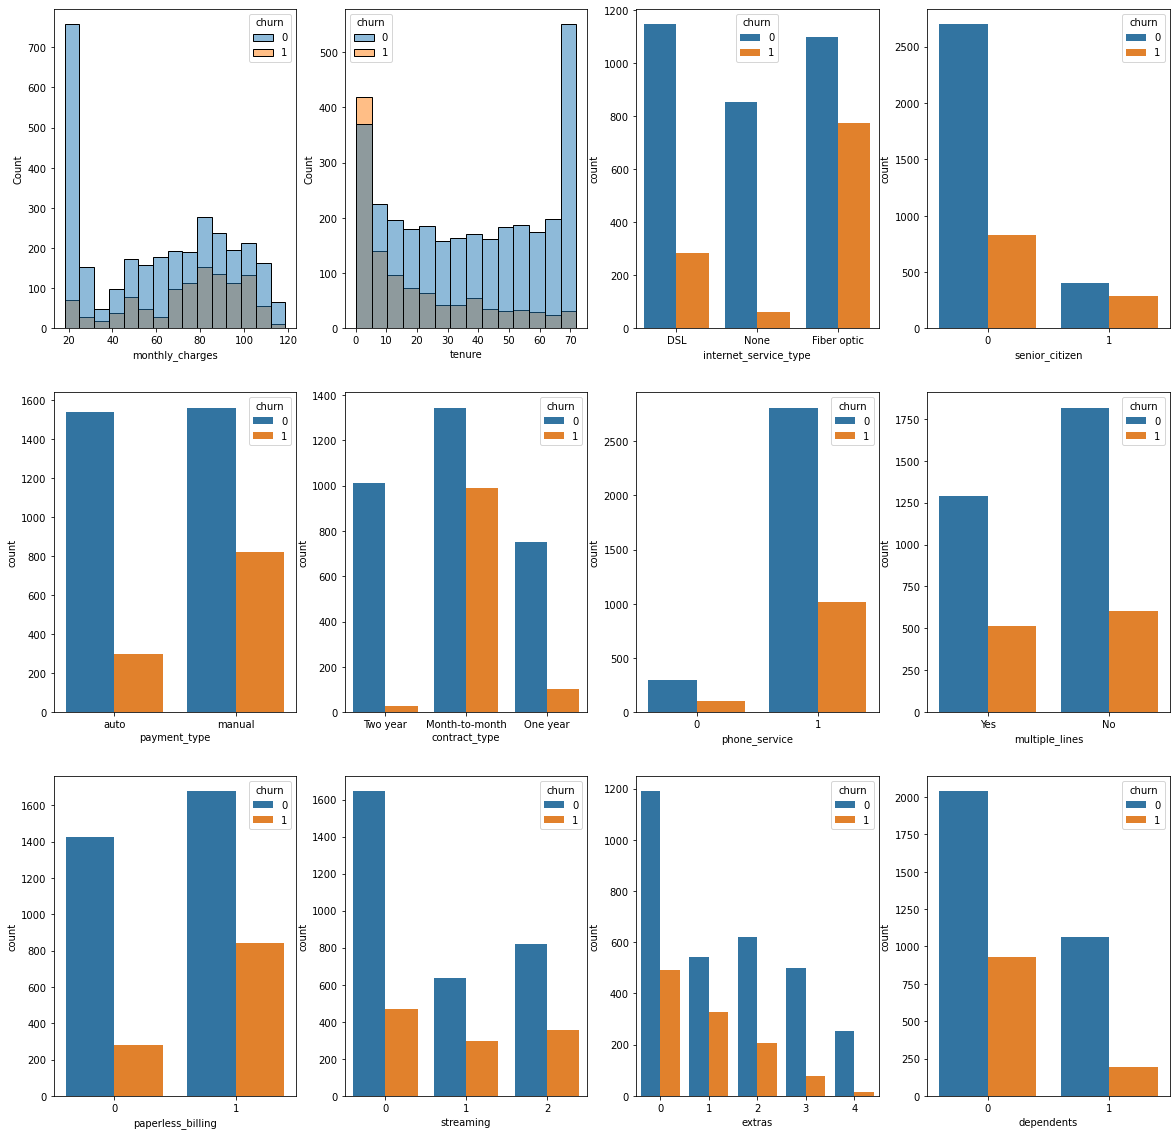

In [9]:
# graphical representations of bivariate analysis of selected features against churn

plt.figure(figsize=[20,20])
plt.subplot(341)
sns.histplot(x=train_telco.monthly_charges, hue=train_telco.churn)
plt.subplot(342)
sns.histplot(x=train_telco.tenure, hue=train_telco.churn)
plt.subplot(343)
sns.countplot(x='internet_service_type', hue='churn', data=train_telco)
plt.subplot(344)
sns.countplot(x=train_telco.senior_citizen, hue=train_telco.churn)
plt.subplot(345)
sns.countplot(x='payment_type', hue='churn', data=train_telco)
plt.subplot(346)
sns.countplot(x='contract_type', hue='churn', data=train_telco)
plt.subplot(347)
sns.countplot(x='phone_service', hue='churn', data=train_telco)
plt.subplot(348)
sns.countplot(x='multiple_lines', hue='churn', data=train_telco)
plt.subplot(349)
sns.countplot(x='paperless_billing', hue='churn', data=train_telco)
plt.subplot(3,4,10)
sns.countplot(x='streaming', hue='churn', data=train_telco)
plt.subplot(3,4,11)
sns.countplot(x='extras', hue='churn', data=train_telco)
plt.subplot(3,4,12)
sns.countplot(x='dependents', hue='churn', data=train_telco)
plt.show()

#### Findings:

- The average monthly charge for customers who churned was 74.9 percent.

- Churn decreases as tenure increases.

- Senior citizens are more likely to churn than non-senior citizens.

- Customers with fiber optic internet service type are more likely to churn than no internet service and DSL.

- Customers with automatic payment are less likely to churn.

- Customers with contracts are less likely to churn than month-to-month customers.

- Customers without paperless billing appear less likely to churn.

- Customers with dependents are less likely to churn.



### Multivariate analysis

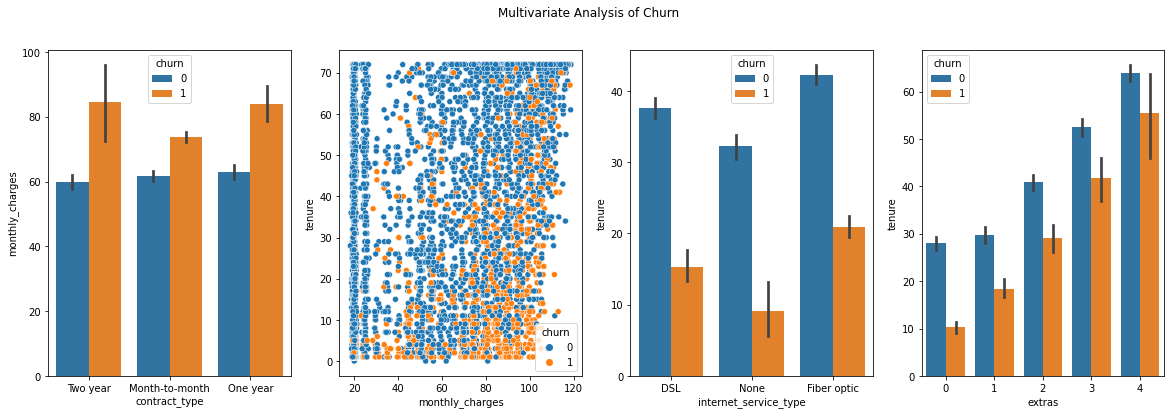

In [103]:
# # graphical representations of multivariate analyses of selected features against churn

plt.figure(figsize=[20,6])
plt.suptitle('Multivariate Analysis of Churn')
plt.subplot(141)
sns.barplot(x=train_telco.contract_type, y=train_telco.monthly_charges, hue=train_telco.churn)
plt.subplot(142)
sns.scatterplot(x=train_telco.monthly_charges, y=train_telco.tenure, hue=train_telco.churn)
plt.subplot(143)
sns.barplot(x=train_telco.internet_service_type, y=train_telco.tenure, hue=train_telco.churn)
plt.subplot(144)
sns.barplot(x=train_telco.extras, y=train_telco.tenure, hue=train_telco.churn)

plt.show()

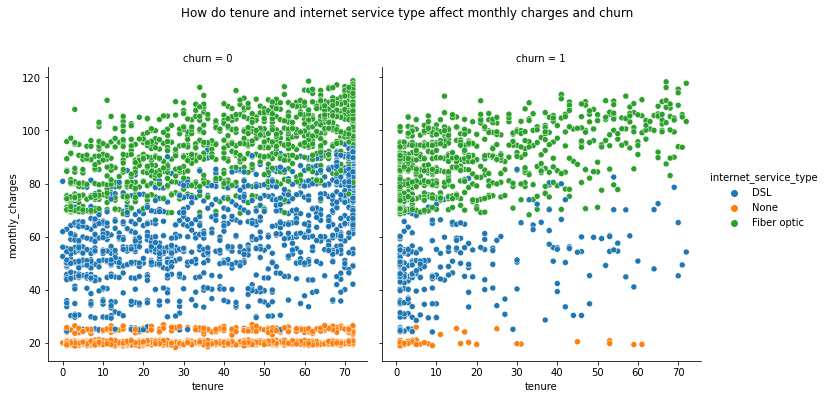

In [119]:
# graph of the relationship between monthly charges, tenure, internet service type, and churn

sns.relplot(data=train_telco, x=train_telco.tenure, y=train_telco.monthly_charges, 
            col=train_telco.churn, hue=train_telco.internet_service_type)
plt.suptitle('How do tenure and internet service type affect monthly charges and churn', y=1.1)
plt.show()

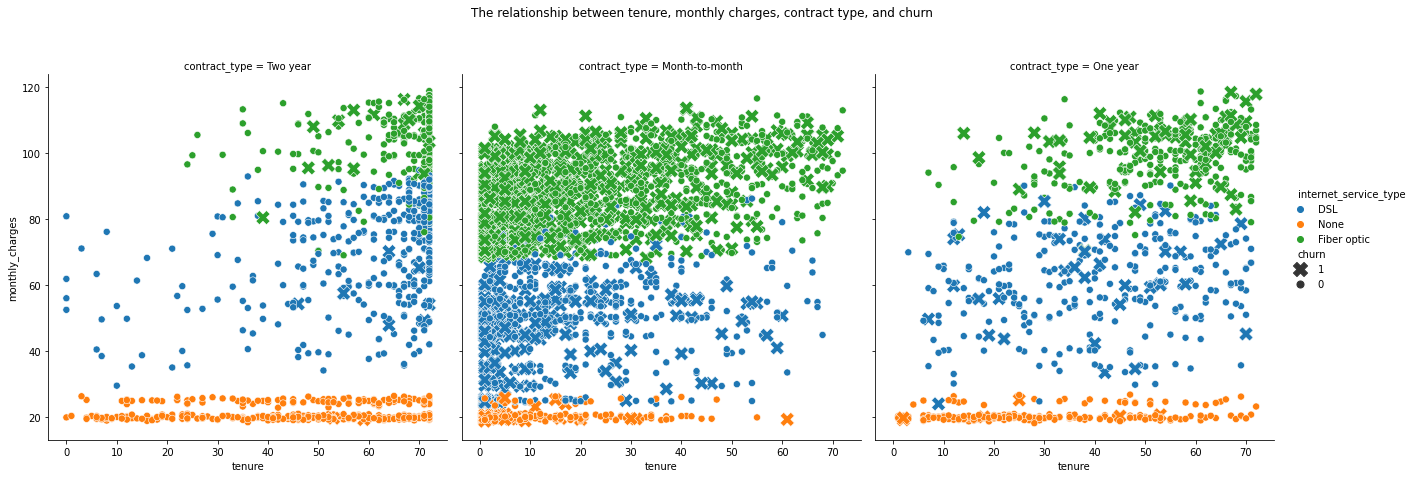

In [118]:
# graph of the relationship between monthly charges, tenure, and contract type, and churn
sns.relplot(data=train_telco, x=train_telco.tenure, y=train_telco.monthly_charges, 
            col=train_telco.contract_type, hue=train_telco.internet_service_type, style=train_telco.churn, 
            size=train_telco.churn, size_order=[1,0], sizes=[200,50], height=6, aspect=1)
plt.suptitle('The relationship between tenure, monthly charges, contract type, and churn', y=1.1)
plt.show()

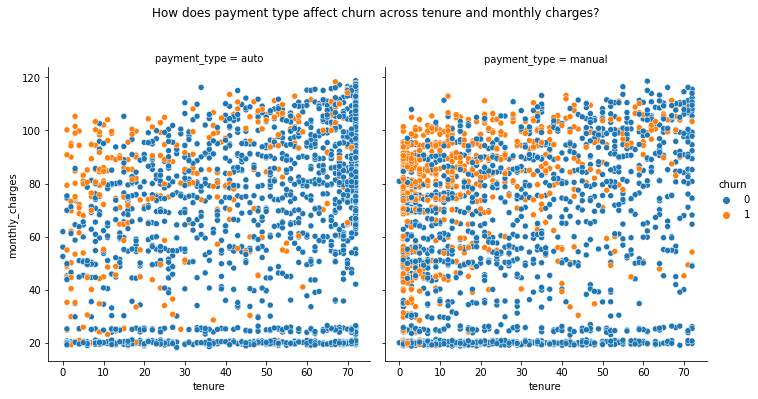

In [121]:
# graph of the relationship between monthly charges, tenure, payment type, and churn
sns.relplot(data=train_telco, x=train_telco.tenure, y=train_telco.monthly_charges, 
            col=train_telco.payment_type, hue=train_telco.churn)
plt.suptitle('How does payment type affect churn across tenure and monthly charges?', y=1.1)
plt.show()

#### Findings:

- Higher monthly charges appears to increase the likelihood of churn across all contract types.

- Customers with higher monthly charges and lower tenure appear to have a greater likelihood of churn.

- More customers have fiber optic service than the other types; these customers also have the highest monthly charges overall.

- Customers without extra services who have higher monthly charges are more likely to churn than customers with extra services.

- Customers with low tenure are more likely to churn regardless of how many extra services they have or the type of internet service they have, but customers with no internet service and high tenure appear to have the lowest rate of churn.

### Hypothesis Testing

In [14]:
# set alpha for statistical tests
alpha= 0.05

H0: There is no linear correlation between monthly charges and churn.

Ha: There is a linear correlation between monthly charges and churn.

In [15]:
# correlation test for the relationship between monthly charges and churn
corr, p = stats.pearsonr(train_telco.monthly_charges, train_telco.churn)
corr, p

(0.19733529945537656, 2.3330208636155277e-38)

In [16]:
# determine whether or not to reject the null hypothesis based on p-value
if p < alpha:
    print("We reject the null hypothesis that there is no linear correlation between monthly charges and churn.")
else:
    print("We fail to reject the null hypothesis that there is no linear correlation between monthly charges and churn.")

We reject the null hypothesis that there is no linear correlation between monthly charges and churn.


H0: There is no linear correlation between tenure and churn.

Ha: There is a linear correlation between tenure and churn.

In [17]:
# correlation calculation for tenure and churn; the two variables are correlated with an r of .34
corr, p = stats.pearsonr(train_telco.tenure, train_telco.churn)
corr, p

(-0.3398785497306553, 9.804162371170059e-115)

In [18]:
# determine whether or not to reject the null hypothesis based on p-value
if p < alpha:
    print("We reject the null hypothesis that there is no linear correlation between tenure and churn.")
else:
    print("We fail to reject the null hypothesis that there is no linear correlation between tenure and churn.")

We reject the null hypothesis that there is no linear correlation between tenure and churn.


H0: There is no association between internet service type and churn (the features are independent).

Ha: There is an association between internet service type and churn.

In [19]:
# chi2 test for an association between internet service type and churn
observed = pd.crosstab(train_telco.internet_service_type, train_telco.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print('Observed')
print(observed.values)
print('\nExpected')
print(expected.astype(int))
print(f'\nchi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[1149  283]
 [1100  776]
 [ 855   62]]

Expected
[[1052  379]
 [1378  497]
 [ 673  243]]

chi^2 = 429.2846
p     = 0.0000


In [20]:
# determine whether or not to reject the null hypothesis based on p-value
if p < alpha:
    print("We reject the null hypothesis that there is no association between internet service type and churn.")
else:
    print("We fail to reject the null hypothesis that there is no association between internet service type and churn.")

We reject the null hypothesis that there is no association between internet service type and churn.


H0: There is no association between contract type and churn (the features are independent).

Ha: There is an association between contract type and churn.

In [21]:
# chi2 test for the association between contract type and churn
observed = pd.crosstab(train_telco.contract_type, train_telco.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print('Observed')
print(observed.values)
print('\nExpected')
print(expected.astype(int))
print(f'\nchi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[1344  991]
 [ 750  104]
 [1010   26]]

Expected
[[1715  619]
 [ 627  226]
 [ 761  274]]

chi^2 = 700.1525
p     = 0.0000


In [22]:
# determine whether or not to reject the null hypothesis based on p-value
if p < alpha:
    print("We reject the null hypothesis that there is no association between contract type and churn.")
else:
    print("We fail to reject the null hypothesis that there is no association between contract type and churn.")

We reject the null hypothesis that there is no association between contract type and churn.


#### Hypothesis Test Findings:

- Correlation statistical testing found a linear correlation between monthly charges and churn with an r-value of .197 and a correlation between tenure and churn with an r-value of .340.

- Chi2 tests on the associations between internet service type, contract type, and all other selected features showed relationships with churn. I included the tests for the two most significant features in this report.

## Modeling

#### Baseline

In [23]:
# Baseline prediction is customers do not churn

baseline = len(train_telco[train_telco.churn == 0]) / len(train_telco)
baseline

0.7346745562130178

- The baseline for this dataset is that customers do not churn; the baseline accuracy is 73 percent.

#### Model 1: Decision Tree

In [24]:
# Model 1 is a decision tree with a maximum depth of 4

model1 = DecisionTreeClassifier(max_depth=4)

# assign the selected features for model 1 to a variable
X_col1 = ['tenure', 'monthly_charges', 'contract_type_id', 'internet_service_type_id', 'senior_citizen', 
          'partner', 'dependents', 'extras', 'streaming']
# assign the target feature to a variable
y_col1 = 'churn'
# assign variables to fit and train the model using the train dataset
X_train1, y_train1 = train_telco[X_col1], train_telco[y_col1]
# assign variables to validate the model using the validate dataset
X_validate1, y_validate1 = validate_telco[X_col1], validate_telco[y_col1]

In [25]:
# fit the model and print the train and validate scores

model1.fit(X_train1, y_train1)
print(f'training score: {model1.score(X_train1, y_train1):.2%}')
print(f'validate score: {model1.score(X_validate1, y_validate1):.2%}')

# make predictions for model 1 and print the classification report for train
y_pred1 = model1.predict(X_train1)
y_pred_proba1 = model1.predict_proba(X_train1)
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(model1.score(X_train1, y_train1)))
print(classification_report(y_train1, y_pred1))

training score: 79.05%
validate score: 79.84%
Accuracy of random forest classifier on training set: 0.79
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      3104
           1       0.64      0.48      0.55      1121

    accuracy                           0.79      4225
   macro avg       0.73      0.69      0.71      4225
weighted avg       0.78      0.79      0.78      4225



In [26]:
# make predictions for model 1 on validate and print the classification report

y_pred1 = model1.predict(X_validate1)
y_pred_proba1 = model1.predict_proba(X_validate1)
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(model1.score(X_validate1, y_validate1)))
print(classification_report(y_validate1, y_pred1))

Accuracy of random forest classifier on test set: 0.80
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.53      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



#### Model 1 Findings:

- This model performed above baseline accuracy with a score of 79 percent on train and 80 percent on validate.

- Reducing the number of features or changing the maximum depth does not result in significantly higher accuracy scores without overfitting.

#### Model 2: Random Forest

In [27]:
# Model 2 is a random forest with a maximum depth of 14 and minimum sample leaf size of 14

model2 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', min_samples_leaf=14, 
                                 n_estimators=100, max_depth=14, random_state=217)

# selected features for the model are saved into a variable
X_col2 = ['tenure', 'monthly_charges', 'contract_type_id', 'internet_service_type_id', 'extras', 'streaming', 
          'paperless_billing', 'senior_citizen', 'dependents', 'partner']
# assign the target feature for model 2 into a variable
y_col2 = 'churn'
# assign variables to fit and train the model using the train dataset and selected features
X_train2, y_train2 = train_telco[X_col2], train_telco[y_col2]
# assign variables to validate the model on the validate dataset
X_validate2, y_validate2 = validate_telco[X_col2], validate_telco[y_col2]

In [28]:
# fit the model using the selected features against train

model2.fit(X_train2, y_train2)

RandomForestClassifier(max_depth=14, min_samples_leaf=14, random_state=217)

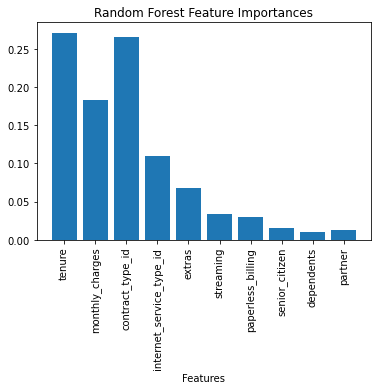

In [29]:
# graphical representation of the feature importances for model 2

plt.bar(X_train2.columns, model2.feature_importances_)
plt.title('Random Forest Feature Importances')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.show()

In [123]:
# make predictions for model 2 on train and print the scores and classification report

y_pred2 = model2.predict(X_train2)
y_pred_proba2 = model2.predict_proba(X_train2)
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(model2.score(X_train2, y_train2)))
print(classification_report(y_train2, y_pred2))

Accuracy of random forest classifier on training set: 0.82
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      3104
           1       0.72      0.52      0.61      1121

    accuracy                           0.82      4225
   macro avg       0.78      0.73      0.74      4225
weighted avg       0.81      0.82      0.81      4225



In [124]:
# make predictions for model 2 on validate; print the scores and the classification report

y_pred2 = model2.predict(X_validate2)
y_pred_proba2 = model2.predict_proba(X_validate2)
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(model2.score(X_validate2, y_validate2)))
print(classification_report(y_validate2, y_pred2))

Accuracy of random forest classifier on test set: 0.81
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1035
           1       0.69      0.52      0.59       374

    accuracy                           0.81      1409
   macro avg       0.77      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



#### Model 2 Findings:

- This model performs better than baseline with the selected features; the accuracy of the model on the training and validate is 82 and 81 percent, respectively.

- The random forest performs best with a maximum depth and number of sample leaves between 14 and 18. I chose 14 for both the depth and leaves.

#### Model 3: K Nearest Neighbors

In [32]:
# Model 3 is a K Nearest Neighbors model with 48 neighbors and uniform weights

model3 = KNeighborsClassifier(n_neighbors=48, weights='uniform')
# assign selected features for model 3 to a variable
X_col3 = ['tenure', 'monthly_charges', 'dependents', 'contract_type_id', 'extras', 'internet_service_type_id', 
          'payment_type_id', 'partner', 'senior_citizen']
# assign the target feature to a variable
y_col3 = 'churn'
# assign variables for fitting and training the model
X_train3, y_train3 = train_telco[X_col3], train_telco[y_col3]
X_validate3, y_validate3 = validate_telco[X_col3], validate_telco[y_col3]

In [33]:
# fit the KNN model
model3.fit(X_train3, y_train3)

KNeighborsClassifier(n_neighbors=48)

In [34]:
# make predictions for model 3 on train and print the scores and classification report
y_pred3 = model3.predict(X_train3)
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(model3.score(X_train3, y_train3)))
print(classification_report(y_train3, y_pred3))

Accuracy of KNN classifier on training set: 0.80
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      3104
           1       0.69      0.42      0.52      1121

    accuracy                           0.80      4225
   macro avg       0.75      0.68      0.70      4225
weighted avg       0.78      0.80      0.78      4225



In [35]:
# make predictions for model 3 on validate; print the scores and the classification report
y_pred3 = model3.predict(X_validate3)
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(model3.score(X_validate3, y_validate3)))
print(classification_report(y_validate3, y_pred3))

Accuracy of KNN classifier on test set: 0.80
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1035
           1       0.68      0.46      0.55       374

    accuracy                           0.80      1409
   macro avg       0.75      0.69      0.71      1409
weighted avg       0.79      0.80      0.78      1409



In [36]:
# Model 4 is a logistic regression with a maximum iterations of 200

model4 = LogisticRegression(random_state=217, max_iter=200, solver='lbfgs')

# save the selected features for the model into a variable
X_col4 = ['tenure', 'monthly_charges', 'contract_type_id', 'internet_service_type_id']
# save the target into a variable
y_col4 = 'churn'
# create the variables for fitting the model
X_train4, y_train4 = train_telco[X_col4], train_telco[y_col4]
X_validate4, y_validate4 = validate_telco[X_col4], validate_telco[y_col4]

In [37]:
# fit the logistic regression model on train variables
model4.fit(X_train4, y_train4)

LogisticRegression(max_iter=200, random_state=217)

In [38]:
# print the coefficients for the features
print('Coefficient: \n', model4.coef_)
print('Intercept: \n', model4.intercept_)

Coefficient: 
 [[-0.03337827  0.02829283 -1.06011475 -0.05711007]]
Intercept: 
 [-0.46039614]


In [39]:
# make predictions for model 4 on train and print the scores and classification report
y_pred4 = model4.predict(X_train4)
y_pred_proba4 = model4.predict_proba(X_train4)
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(model4.score(X_train4, y_train4)))

Accuracy of Logistic Regression classifier on training set: 0.79


In [40]:
# make predictions for model 4 on validate; print the scores and the classification report
y_pred4 = model4.predict(X_validate4)

print("Model 4: solver = lbfgs, c = 1")
# accuracy of model 4
print('Accuracy: {:.2f}'.format(model4.score(X_validate4, y_validate4)))
# confusion matrix of model 4
print(confusion_matrix(y_validate4, y_pred4))
# classification report of model 4
print(classification_report(y_validate4, y_pred4))

Model 4: solver = lbfgs, c = 1
Accuracy: 0.80
[[927 108]
 [180 194]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.64      0.52      0.57       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



#### Modeling Findings:

- Baseline prediction is that customers do not churn, with an overall accuracy of 73 percent.

- Decision Tree model performed at 80 percent accuracy with the selected features. The maximum depths of 4 and 5 produced best results.

- Random Forest performed at 80-82 percent accuracy depending on the maximum depth and minimum number of samples per leaf. The combination with the best accuracy and the lowest difference between train and validate is a maximum depth of 18 and a minimum of 18 samples per leaf. I chose 14 and 14 in an attempt to increase accuracy. 

- The K nearest neighbors model performed at 80 percent accuracy with less than 1 percent difference in accuracy between train and validate. This model works best with 48 neighbors and uniform weights.

- Logistic regression performed at 80 percent accuracy with selected features and 200 maximum iterations.

- Since this project focuses on accuracy, I will choose the random forest model for testing.

## Select and Test the Best Model

In [128]:
# Model 2 (Random Forest) is used on the test set

# set the test variables using the test set and features from model 2
X_test, y_test = test_telco[X_col2], test_telco[y_col2]
# calculate predictions for the test set
y_pred = model2.predict(X_test)
# calculate the probabilites for the test set
y_pred_proba = model2.predict_proba(X_test)
# print the model accuracy scores and classification report for the test set
print('Accuracy: {:.2f}'.format(model2.score(X_test, y_test)))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.80
[[945  90]
 [187 187]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.68      0.50      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



#### Test Findings:

- The random forest model performed at 80 percent overall accuracy on the test set. The probability threshold was most accurate at 0.4.

- This model provides a 7 percent increase in accuracy compared to baseline predictions.

## Create .csv for Predictions

- I created a dataframe of the probabilites of churn for each test observation and concatenated this dataframe to the associated customer id and prediction. The concatenated dataframe is saved as 'predictions.csv' and is available in the repository.

In [95]:
# save the test set probabilities into a dataframe
proba = pd.DataFrame(y_pred_proba, columns=['No Churn', 'prob_churn'])
# save the customer id from the test set into a dataframe
test = pd.DataFrame(test_telco.customer_id)

In [96]:
# reset the index for concatenation
test_id = test.reset_index()

In [97]:
# rename the index with observation number in case needed
test_id = test_id.rename(columns={'index':'number'})

In [98]:
# concatenate the test_id and proba dataframes
test_df = pd.concat([test_id, proba], axis=1)

In [99]:
# drop the number and No Churn columns for final csv
test_df = test_df.drop(columns=['number', 'No Churn'])

In [100]:
# add the predictions column with the predictions from the test set; 1 = churn, 0 = no churn
test_df['prediction'] = y_pred

In [101]:
# make sure the dataframe has been created successfully
test_df

,customer_id,prob_churn,prediction
0,4163-HFTUK,0.029409,0
1,2433-KMEAS,0.141040,0
2,3022-BEXHZ,0.120124,0
3,9866-QEVEE,0.490940,0
4,5567-GZKQY,0.012300,0
...,...,...,...
1404,5928-QLDHB,0.554722,1
1405,7901-TBKJX,0.447145,0
1406,0734-OXWBT,0.412804,0
1407,0842-IWYCP,0.212406,0


In [102]:
# save the dataframe to a csv
test_df.to_csv('predictions.csv')

## Conclusion and Recommendations

- Customers with low monthly charges, high tenure, and a two-year contract have the lowest likelihood of churn. Although the models performed similarly for accuracy, none of the models performed above baseline for recall. 
- If Telco wants to predict customers who actually churn, I would recommend a different model or retraining the selected model for increased recall.
- Recommendations for Telco to improve churn:
    - Get the customers into a contract; the two-year contract customers had the lowest amount of churn, followed by one-year contracts. Month-to-month customers churned more than both contracts combined.
    - Increase the number of extra services per customer; customers with 4 extra services had a much lower rate of churn than customers with no extra services
    - Keep the monthly charges below 60 dollars if possible; customers above the mean monthly charge are more likely to churn
    - Get the customers to stay for over one year; customers are most likely to churn within the first year of service
    - Encourage the customers to renew their contracts; churn is more likely to occur within the first few months after a contract ends.
- If I had more time, I would search the data for more intricate relationships between features that are indicative of churn using multivariate analysis. I would also tune the models for increased recall and precision for churn.
